In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 2s (4,952 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 122545 files and di

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from prophet import Prophet
plt.rc('font', family='NanumBarunGothic')
from sklearn.metrics import mean_absolute_error as mae

In [ ]:
train = pd.read_csv('traindata.csv')
test = pd.read_csv('testdata.csv')

train['y'] = (train['광진구']+train['동대문구']+train['성동구']+train['중랑구'])/4
test['y'] = (test['광진구']+test['동대문구']+test['성동구']+test['중랑구'])/4

train['ds'] = pd.to_datetime(train.date)
test['ds'] = pd.to_datetime(test.date)

train

,date,광진구,동대문구,성동구,중랑구,y,ds
0,2018-01-01,0.592,0.368,0.580,0.162,0.4255,2018-01-01
1,2018-01-02,0.840,0.614,1.034,0.260,0.6870,2018-01-02
2,2018-01-03,0.828,0.576,0.952,0.288,0.6610,2018-01-03
3,2018-01-04,0.792,0.542,0.914,0.292,0.6350,2018-01-04
4,2018-01-05,0.818,0.602,0.994,0.308,0.6805,2018-01-05
...,...,...,...,...,...,...,...
1091,2020-12-27,3.528,2.604,3.258,2.038,2.8570,2020-12-27
1092,2020-12-28,4.542,3.588,4.506,2.480,3.7790,2020-12-28
1093,2020-12-29,3.694,3.054,3.222,2.118,3.0220,2020-12-29
1094,2020-12-30,2.366,1.812,2.012,1.174,1.8410,2020-12-30


In [ ]:
train = train[['y', 'ds']]
test = test[['y', 'ds']]



In [ ]:
## rain effect 추가
rainday = pd.read_csv('scenario_45.csv', index_col = 0)
ind =  ['2021.01.5', '2021.01.27', '2021.02.2', '2021.02.19', '2021.02.22', '2021.03.04', '2021.03.11', '2021.03.18', '2021.04.02', '2021.04.14', '2021.04.16', '2021.04.17', '2021.04.30', '2021.05.10', '2021.05.15', '2021.05.17', '2021.05.20', '2021.05.23', '2021.06.01', '2021.06.23', '2021.06.25', '2021.06.29', '2021.07.04', '2021.07.08', '2021.07.13', '2021.07.17', '2021.07.19', '2021.07.20', '2021.07.22', '2021.07.28', '2021.07.29', '2021.08.06', '2021.08.07', '2021.08.08', '2021.08.10', '2021.08.11', '2021.08.13', '2021.08.15', '2021.08.17', '2021.08.24', '2021.08.27', '2021.08.29', '2021.09.05', '2021.09.07', '2021.09.08', '2021.09.11', '2021.09.20', '2021.10.08', '2021.10.23', '2021.11.01', '2021.11.02', '2021.11.05', '2021.11.14', '2021.12.10', '2021.12.18']
rainday['k_lst'] = ind
rainday['k_lst'] = pd.to_datetime(rainday['k_lst'], format='%Y.%m.%d')
rainday.columns = ['ds', 'y']
rainday.y = rainday.y.astype('float64')
add_rain = rainday[rainday['y'] > 0.07]
add_rain['y'] = 'rain'
add_rain.reset_index(drop=True, inplace=True)

## train set에서의 비오는날
rain_1 = pd.read_csv('peak_2018.csv')
rain_2 = pd.read_csv('peak_2019.csv')
rain_3 = pd.read_csv('peak_2020.csv')

sumdf = pd.concat([rain_1, rain_2, rain_3]).dropna()

# 0.3, 0.15보다 많이 오는 날에 대해서 rain effect를 정의하려고 한다.
rain_up_3 = sumdf.query('rain >= 0.3')['date']
rain_up_15 = sumdf.query('rain >= 0.15')['date']
rain_up_07 = sumdf.query('rain >= 0.07')['date']


## 휴일효과 고려할 데이터프레임 생성
event_df1 = pd.DataFrame(rain_up_3)
event_df2 = pd.DataFrame(rain_up_15)
event_df3 = pd.DataFrame(rain_up_07)

event_df1['holiday'] = 'rain'
event_df2['holiday'] = 'rain'
event_df3['holiday'] = 'rain'

event_df1['ds'] = pd.to_datetime(event_df1['date'])
event_df2['ds'] = pd.to_datetime(event_df2['date'])
event_df3['ds'] = pd.to_datetime(event_df3['date'])

<ipython-input-4-8f8466b73d0a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  add_rain['y'] = 'rain'


In [ ]:
m = Prophet()



m = m.fit(train)
forecast = m.make_future_dataframe(periods=365)
pred_prophet = m.predict(forecast)
print(mae(test['y'], pred_prophet['yhat'].tail(365)))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy1og6alh/1j6b6ifw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy1og6alh/n_imvdzk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83966', 'data', 'file=/tmp/tmpy1og6alh/1j6b6ifw.json', 'init=/tmp/tmpy1og6alh/n_imvdzk.json', 'output', 'file=/tmp/tmpy1og6alh/prophet_modeli04thdfk/prophet_model-20230529124407.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:44:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:44:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


1.8870944880789002


/usr/local/lib/python3.10/dist-packages/prophet/plot.py:92: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


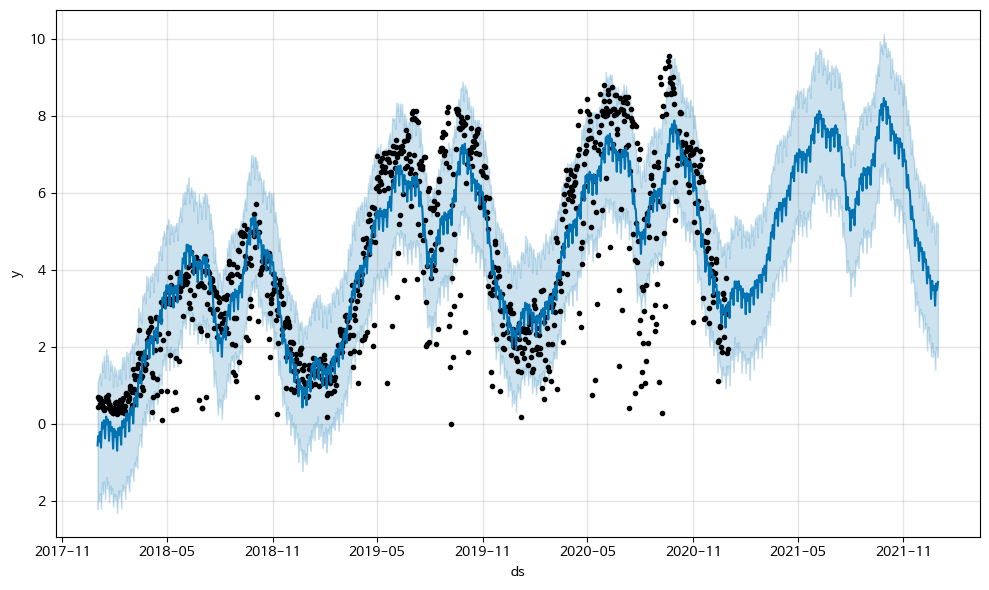

In [ ]:
fig = m.plot(pred_prophet)

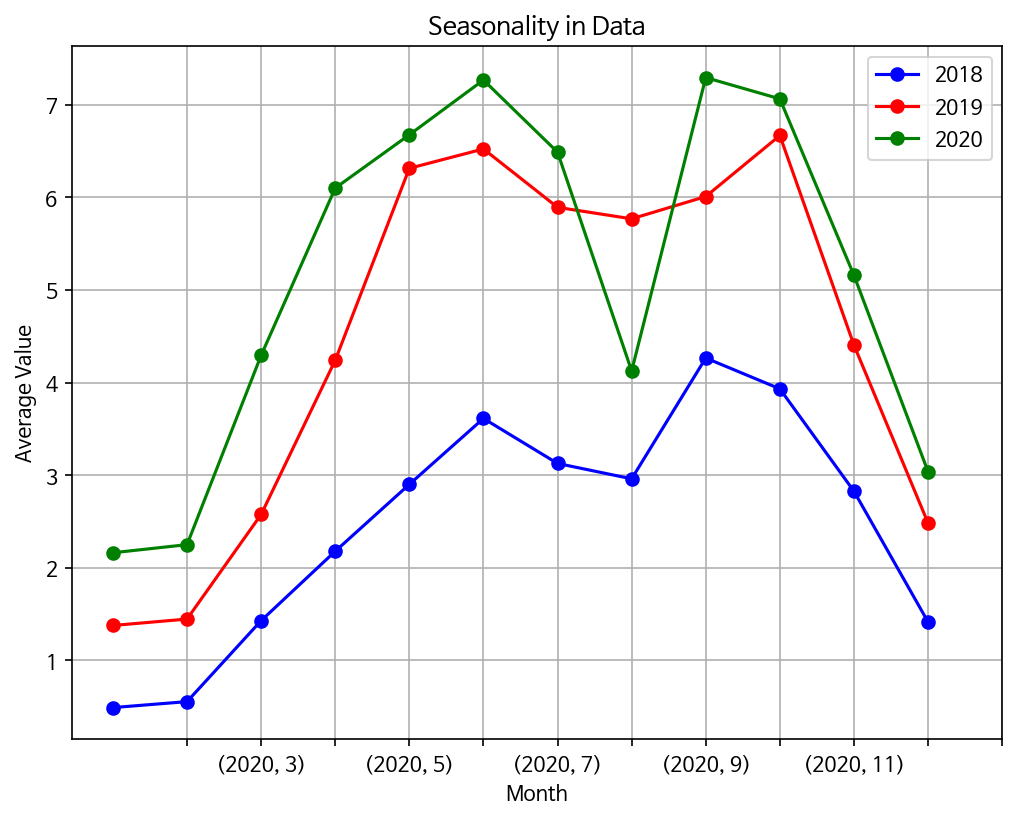

In [ ]:
## 계절성이 증가하므로 승법모형을 사용하겠다는 증거
train_season = train.copy()
train_season['year'] = train_season['ds'].dt.year
train_season['month'] = train_season['ds'].dt.month
train_season['day'] = train_season['ds'].dt.day

monthly_data_1 = train_season.groupby(['year', 'month'])['y'].mean()



# Plot the seasonality
fig, ax = plt.subplots(figsize=(8, 6), dpi=150)
monthly_data_1[:12].plot(ax=ax, color='b', marker='o', linestyle='-', label = '2018')
monthly_data_1[12:24].plot(ax=ax, color='r', marker='o', linestyle='-', label='2019')
monthly_data_1[24:].plot(ax=ax, color='g', marker='o', linestyle='-', label='2020')
plt.xlabel('Month')
plt.ylabel('Average Value')
plt.title('Seasonality in Data')
plt.xticks(range(1, 13))
plt.grid(True)
plt.legend()
# Display the plot
plt.show()


In [ ]:
## 신뢰구간에 해당하지 않는 이상치를 제거하고 피팅하자
# 승법모형 고려 (계절성이 증가하는 추세를 증거로)
## fitting
m = Prophet(

    seasonality_mode='multiplicative',
    seasonality_prior_scale = 2,
    weekly_seasonality=0,
    yearly_seasonality=2,
    holidays = event_df3,
    holidays_prior_scale=1.0,
    interval_width=0.9
)
m.add_country_holidays(country_name='Korea')

m = m.fit(train)
forecast = m.make_future_dataframe(periods=365)

pred_prophet = m.predict(forecast)
print(mae(test['y'], pred_prophet['yhat'].tail(365)))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy1og6alh/717mrimg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy1og6alh/w87sznoh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67710', 'data', 'file=/tmp/tmpy1og6alh/717mrimg.json', 'init=/tmp/tmpy1og6alh/w87sznoh.json', 'output', 'file=/tmp/tmpy1og6alh/prophet_model22x5noy_/prophet_model-20230529124418.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:44:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:44:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


1.592628898155714


/usr/local/lib/python3.10/dist-packages/prophet/plot.py:92: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


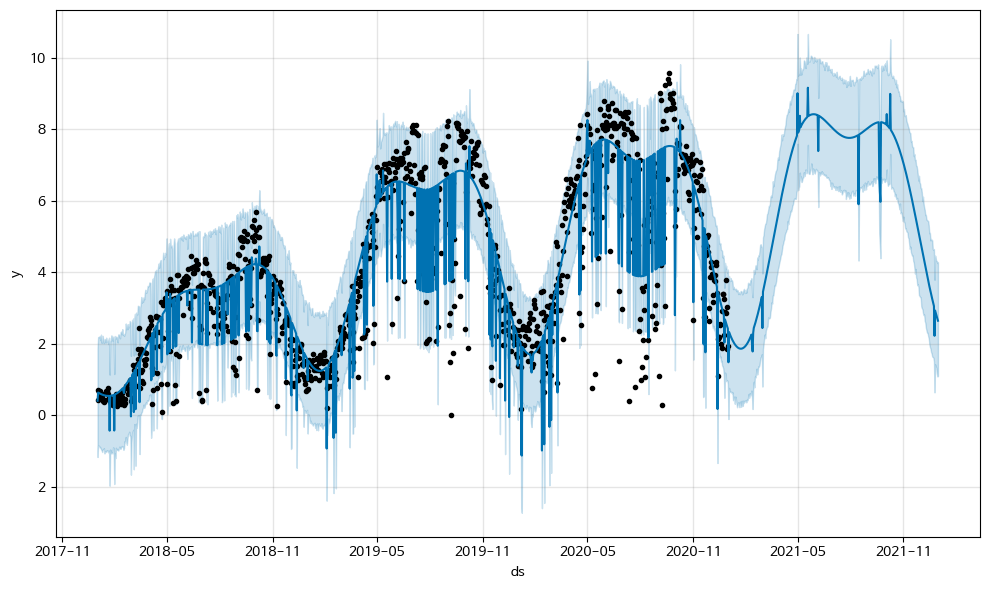

In [ ]:
fig = m.plot(pred_prophet)

In [ ]:
## 신뢰구간에 해당하지 않는 이상치를 제거하고 피팅하자
train_copy = train.copy()
train_copy['yhat_lower'] = pred_prophet['yhat_lower'].head(1096)
train_copy['yhat_upper'] = pred_prophet['yhat_upper'].head(1096)

for i in range(len(train_copy)):
  if train_copy.loc[i, 'y'] < train_copy.loc[i, 'yhat_lower'] :
    train_copy.loc[i, 'y'] = np.nan
  else:
    pass

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


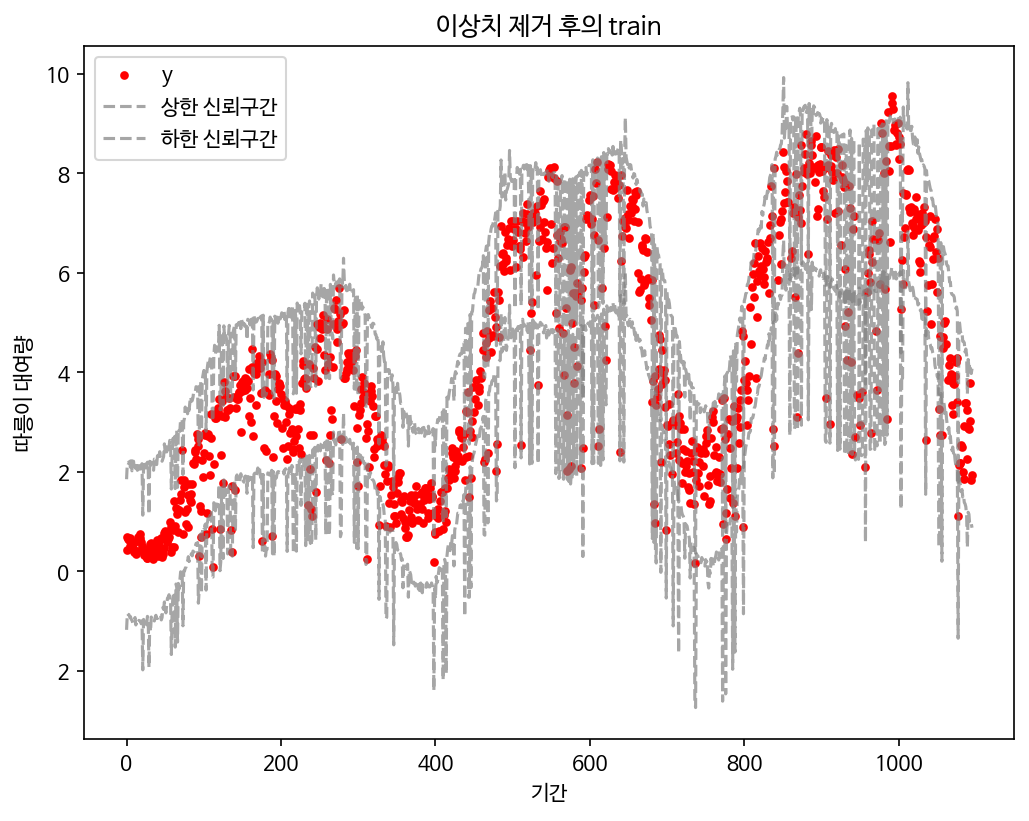

In [ ]:
fig, ax = plt.subplots(figsize=(8,6), dpi=150)
ax.scatter(train_copy.index, train_copy['y'], color='r', s=10, label='y')
train_copy['yhat_lower'].plot(ax=ax, linestyle='--', color='gray', alpha=0.7, label='상한 신뢰구간')
train_copy['yhat_upper'].plot(ax=ax, linestyle='--', color='gray', alpha=0.7, label='하한 신뢰구간')
ax.set_title('이상치 제거 후의 train')
ax.set_xlabel('기간')
ax.set_ylabel('따릉이 대여량')
ax.legend()
plt.show()

In [ ]:
## 이상치 제거 후의 데이터를 가지고 재피팅
m = Prophet(

    seasonality_mode='multiplicative',
    seasonality_prior_scale = 10,
    weekly_seasonality=0,
    yearly_seasonality=2,
    holidays = event_df3,
    holidays_prior_scale=1.0,
    interval_width=0.9
)
m.add_country_holidays(country_name='Korea')

m = m.fit(train_copy)
forecast = m.make_future_dataframe(periods=365)

pred_prophet = m.predict(forecast)
print(mae(test['y'], pred_prophet['yhat'].tail(365)))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy1og6alh/x8dql41o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy1og6alh/fhyg2lrr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72424', 'data', 'file=/tmp/tmpy1og6alh/x8dql41o.json', 'init=/tmp/tmpy1og6alh/fhyg2lrr.json', 'output', 'file=/tmp/tmpy1og6alh/prophet_model1c_j3lh8/prophet_model-20230529124430.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:44:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:44:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


1.491798574956982


/usr/local/lib/python3.10/dist-packages/prophet/plot.py:92: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


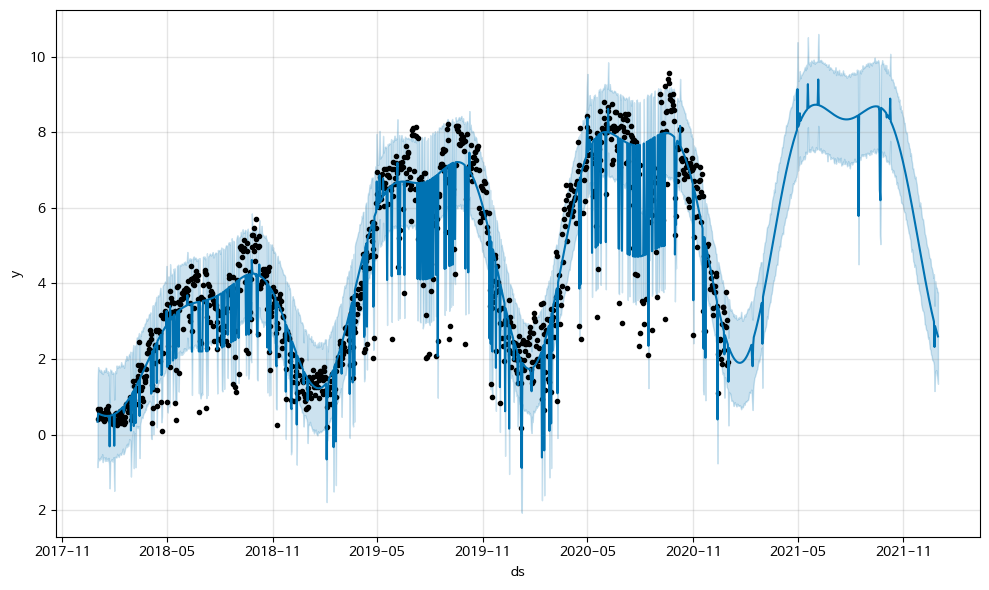

In [ ]:
fig = m.plot(pred_prophet)

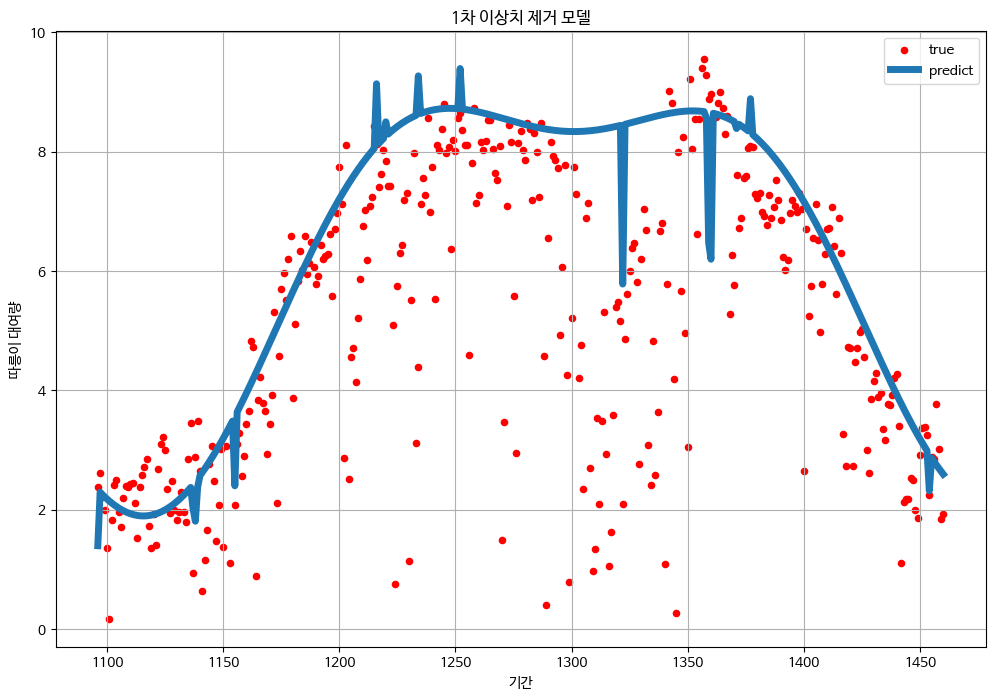

In [ ]:
# 그림으로 확인
# 그림확인
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(forecast.tail(365).index, train['y'].tail(365), color='red', s=20, label = 'true')
pred_prophet['yhat'].tail(365).plot(ax=ax, label = 'predict', lw=5)
ax.set_title('1차 이상치 제거 모델')
ax.set_xlabel('기간')
ax.set_ylabel('따릉이 대여량')
ax.legend()
ax.grid(True)
plt.show()



In [ ]:
train_2019 = train_copy.head(731)


In [ ]:
event_2019 = event_df3[:103]

In [ ]:
## 이상치 제거 후의 데이터를 가지고 재피팅
m = Prophet(

    seasonality_mode='multiplicative',
    seasonality_prior_scale = 10,
    weekly_seasonality=0,
    yearly_seasonality=2,
    holidays = event_df3,
    holidays_prior_scale=1.0,
    interval_width=0.9
)
m.add_country_holidays(country_name='Korea')

m = m.fit(train_copy)
forecast = m.make_future_dataframe(periods=365)

pred_prophet = m.predict(forecast)
print(mae(test['y'], pred_prophet['yhat'].tail(365)))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxei9imw0/msjqh00e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxei9imw0/iysxrxzd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31566', 'data', 'file=/tmp/tmpxei9imw0/msjqh00e.json', 'init=/tmp/tmpxei9imw0/iysxrxzd.json', 'output', 'file=/tmp/tmpxei9imw0/prophet_model0y8p6mlo/prophet_model-20230527123943.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:39:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:39:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


1.4894631344851135


/usr/local/lib/python3.10/dist-packages/prophet/plot.py:92: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


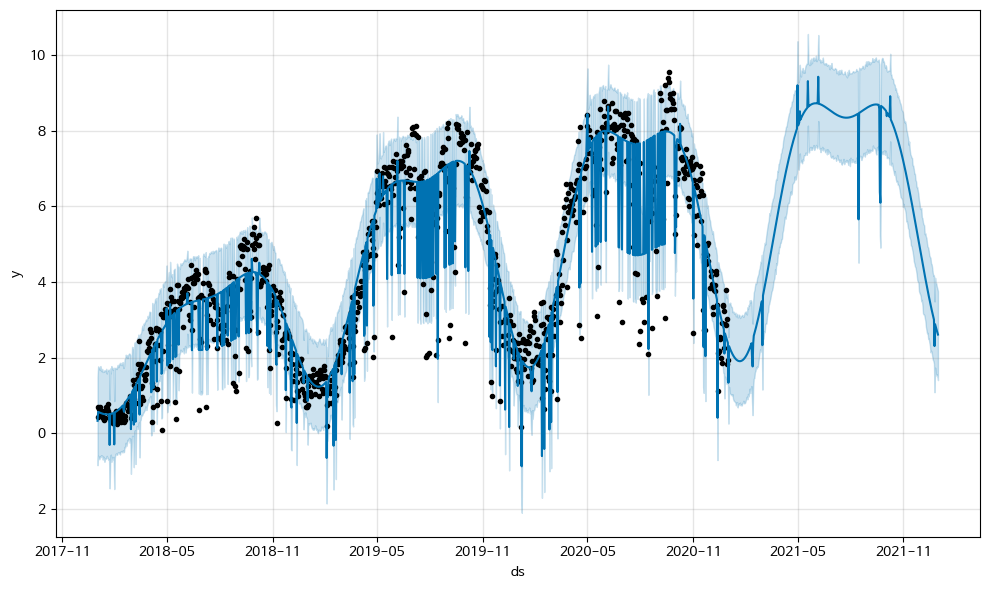

In [ ]:
fig = m.plot(pred_prophet)

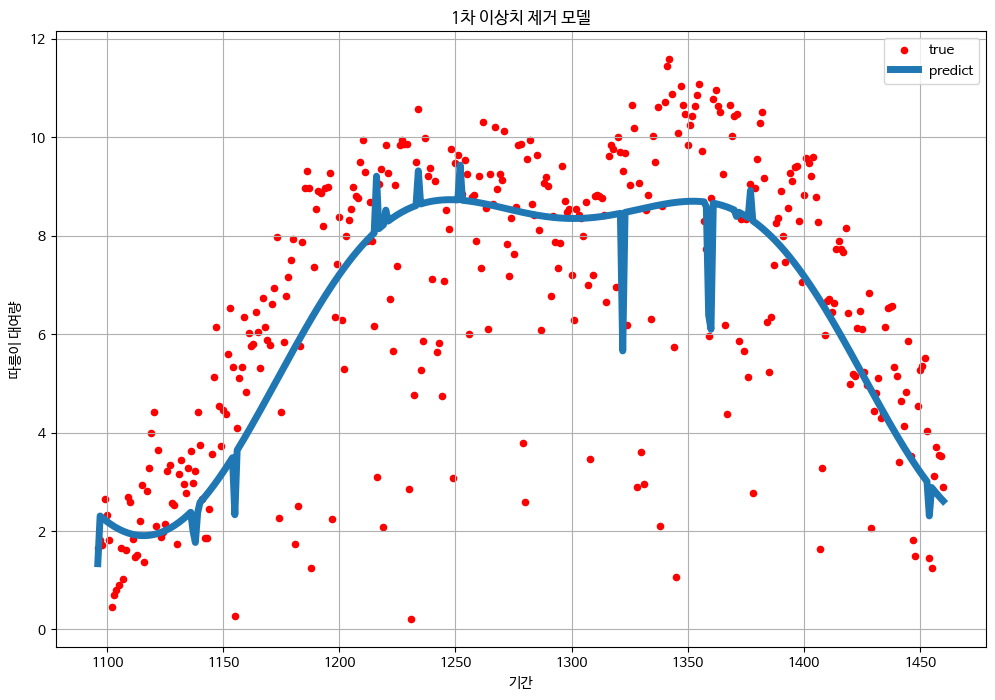

In [ ]:
# 그림으로 확인
# 그림확인
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(forecast.tail(365).index, test['y'], color='red', s=20, label = 'true')
pred_prophet['yhat'].tail(365).plot(ax=ax, label = 'predict', lw=5)
ax.set_title('1차 이상치 제거 모델')
ax.set_xlabel('기간')
ax.set_ylabel('따릉이 대여량')
ax.legend()
ax.grid(True)
plt.show()



In [ ]:
## 신뢰구간에 해당하지 않는 이상치를 제거하고 피팅하자
train_2019_copy = train_2019.copy()
train_2019_copy['yhat_lower'] = pred_prophet['yhat_lower'].head(1096)
train_2019_copy['yhat_upper'] = pred_prophet['yhat_upper'].head(1096)

for i in range(len(train_2019_copy)):
  if train_2019_copy.loc[i, 'y'] < train_2019_copy.loc[i, 'yhat_lower'] :
    train_2019_copy.loc[i, 'y'] = np.nan
  else:
    pass

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


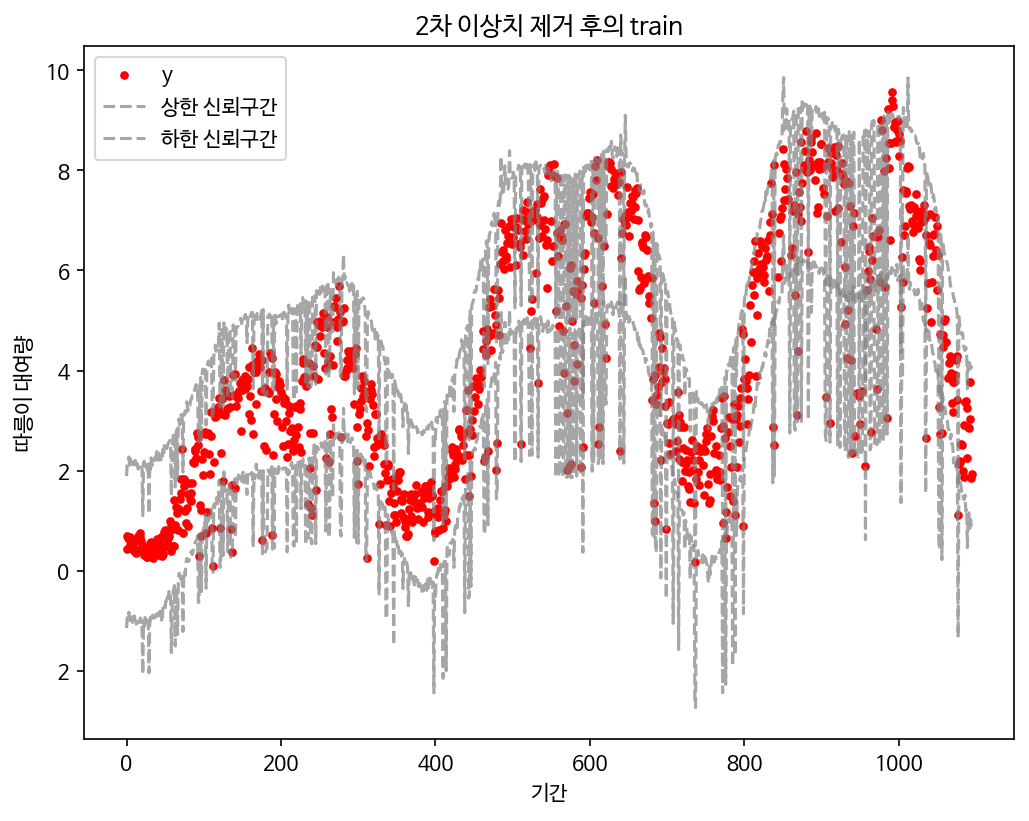

In [ ]:
fig, ax = plt.subplots(figsize=(8,6), dpi=150)
ax.scatter(train_copy.index, train_copy['y'], color='r', s=10, label='y')
train_copy['yhat_lower'].plot(ax=ax, linestyle='--', color='gray', alpha=0.7, label='상한 신뢰구간')
train_copy['yhat_upper'].plot(ax=ax, linestyle='--', color='gray', alpha=0.7, label='하한 신뢰구간')
ax.set_title('2차 이상치 제거 후의 train')
ax.set_xlabel('기간')
ax.set_ylabel('따릉이 대여량')
ax.legend()
plt.show()

In [ ]:
## 이상치 제거 후의 데이터를 가지고 재피팅
m = Prophet(

    seasonality_mode='multiplicative',
    seasonality_prior_scale = 10,
    weekly_seasonality=0,
    yearly_seasonality=2,
    holidays = event_2019,
    holidays_prior_scale=1.0,
    interval_width=0.9
)
m.add_country_holidays(country_name='Korea')

m = m.fit(train_2019_copy)
forecast = m.make_future_dataframe(periods=365)

pred_prophet = m.predict(forecast)
print(mae(train['y'].tail(365), pred_prophet['yhat'].tail(365)))

/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxei9imw0/sl2fxzqu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxei9imw0/w7nc9gpr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2814', 'data', 'file=/tmp/tmpxei9imw0/sl2fxzqu.json', 'init=/tmp/tmpxei9imw0/w7nc9gpr.json', 'output', 'file=/tmp/tmpxei9imw0/prophet_modeltxvva4am/prophet_mod

2.3278631906908847


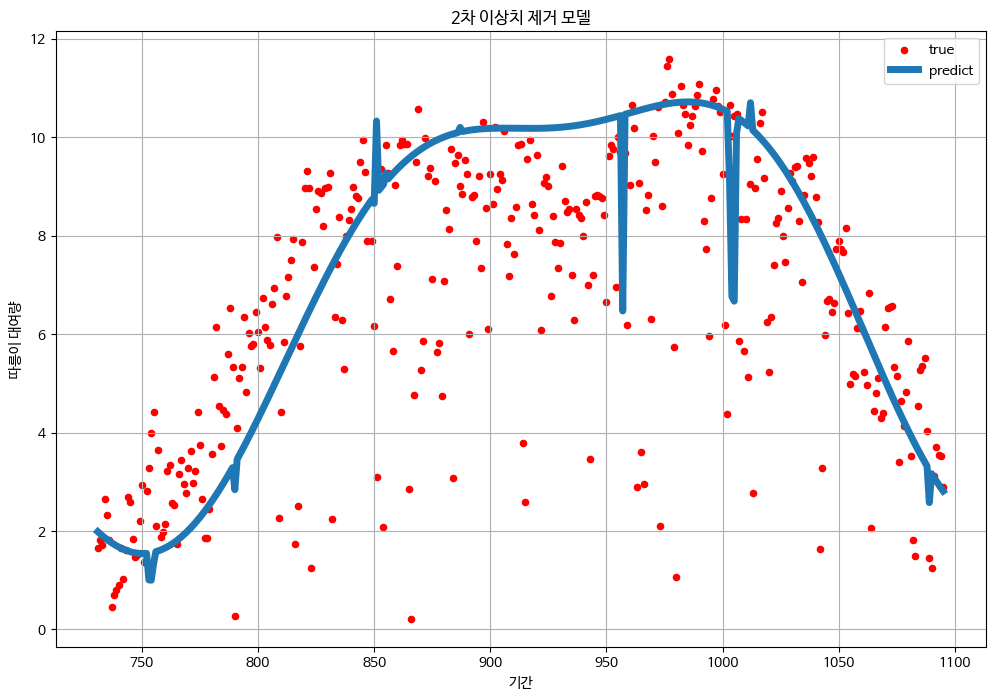

In [ ]:
# 그림으로 확인
# 그림확인
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(forecast.tail(365).index, test['y'], color='red', s=20, label = 'true')
pred_prophet['yhat'].tail(365).plot(ax=ax, label = 'predict', lw=5)
ax.set_title('2차 이상치 제거 모델')
ax.set_xlabel('기간')
ax.set_ylabel('따릉이 대여량')
ax.legend()
ax.grid(True)
plt.show()



In [ ]:
pred_prophet['yhat'] - test

0       0.341225
1       0.520130
2       0.510343
3       0.501026
4       0.492194
          ...   
1091    3.087713
1092    3.014624
1093    2.943958
1094    2.875780
1095    2.810152
Name: yhat, Length: 1096, dtype: float64

In [ ]:
## 이상치 제거 후의 데이터를 가지고 재피팅
m = Prophet(

    seasonality_mode='multiplicative',
    seasonality_prior_scale = 10,
    weekly_seasonality=0,
    yearly_seasonality=2,

    interval_width=0.9
)
m.add_country_holidays(country_name='Korea')

m = m.fit(train_2019_copy)
forecast = m.make_future_dataframe(periods=365)

pred_prophet = m.predict(forecast)
print(mae(train['y'].tail(365), pred_prophet['yhat'].tail(365)))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp01vpifks/kz562e_q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp01vpifks/6jqgith5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80414', 'data', 'file=/tmp/tmp01vpifks/kz562e_q.json', 'init=/tmp/tmp01vpifks/6jqgith5.json', 'output', 'file=/tmp/tmp01vpifks/prophet_modeljqnlxwbx/prophet_model-20230527065126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:51:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:51:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


2.1226324707836985


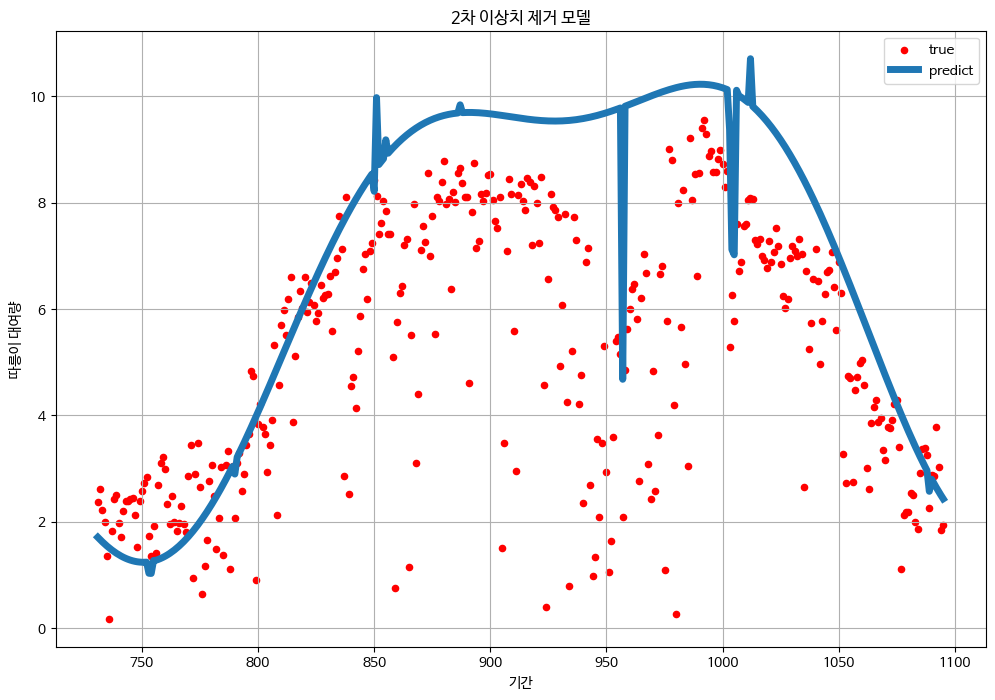

In [ ]:
# 그림으로 확인
# 그림확인
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(forecast.tail(365).index, train['y'].tail(365), color='red', s=20, label = 'true')
pred_prophet['yhat'].tail(365).plot(ax=ax, label = 'predict', lw=5)
ax.set_title('2차 이상치 제거 모델')
ax.set_xlabel('기간')
ax.set_ylabel('따릉이 대여량')
ax.legend()
ax.grid(True)
plt.show()



In [ ]:
for i in range(0,31):
  window_size=i
  moving_avg = pd.Series(pred_prophet['yhat'].tail(365)).rolling(window=window_size).mean()
  print('window_size가 ',i,'일경우의 성능 : ', mae(train['y'].tail(365), moving_avg.fillna(1.5)))

window_size가  0 일경우의 성능 :  3.729708219178082
window_size가  1 일경우의 성능 :  1.9633733431933655
window_size가  2 일경우의 성능 :  1.9814852996367407
window_size가  3 일경우의 성능 :  1.989752640657426
window_size가  4 일경우의 성능 :  1.9957440902226047
window_size가  5 일경우의 성능 :  2.0032152475782805
window_size가  6 일경우의 성능 :  2.000450971470211
window_size가  7 일경우의 성능 :  2.0055121534481146
window_size가  8 일경우의 성능 :  2.011005452093805
window_size가  9 일경우의 성능 :  2.019527032405051
window_size가  10 일경우의 성능 :  2.023086686140914
window_size가  11 일경우의 성능 :  2.0290461221557896
window_size가  12 일경우의 성능 :  2.0367616430463733
window_size가  13 일경우의 성능 :  2.043782240384661
window_size가  14 일경우의 성능 :  2.0521729082175946
window_size가  15 일경우의 성능 :  2.0588892445665783
window_size가  16 일경우의 성능 :  2.068601836861265
window_size가  17 일경우의 성능 :  2.0752035207177606
window_size가  18 일경우의 성능 :  2.082573313041025
window_size가  19 일경우의 성능 :  2.0898518487042548
window_size가  20 일경우의 성능 :  2.097499398227669
window_size가  21 일경우의 성능 :  2.105

In [ ]:
train_2019_copy

,y,ds,yhat_lower,yhat_upper
0,0.4255,2018-01-01,-0.724591,1.365601
1,0.6870,2018-01-02,-0.486681,1.551534
2,0.6610,2018-01-03,-0.561561,1.502042
3,0.6350,2018-01-04,-0.622993,1.496520
4,0.6805,2018-01-05,-0.532826,1.483521
...,...,...,...,...
726,2.2185,2019-12-28,1.112998,3.325900
727,1.7000,2019-12-29,1.034550,3.277719
728,1.9760,2019-12-30,1.028023,3.233627
729,1.6310,2019-12-31,0.968302,3.159036


In [ ]:
train_copy

,y,ds,yhat_lower,yhat_upper
0,0.4255,2018-01-01,-1.148351,1.888534
1,0.6870,2018-01-02,-0.890486,2.205168
2,0.6610,2018-01-03,-0.925457,2.227953
3,0.6350,2018-01-04,-0.833901,2.270380
4,0.6805,2018-01-05,-1.005580,2.105920
...,...,...,...,...
1091,2.8570,2020-12-27,1.153604,4.174434
1092,3.7790,2020-12-28,0.841673,4.133471
1093,3.0220,2020-12-29,1.086497,4.032771
1094,1.8410,2020-12-30,0.892780,4.075436


In [ ]:
residual = np.array(pred_prophet['yhat'].tail(365)) - np.array(test['y'])
residual = residual.reshape(-1, 1)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


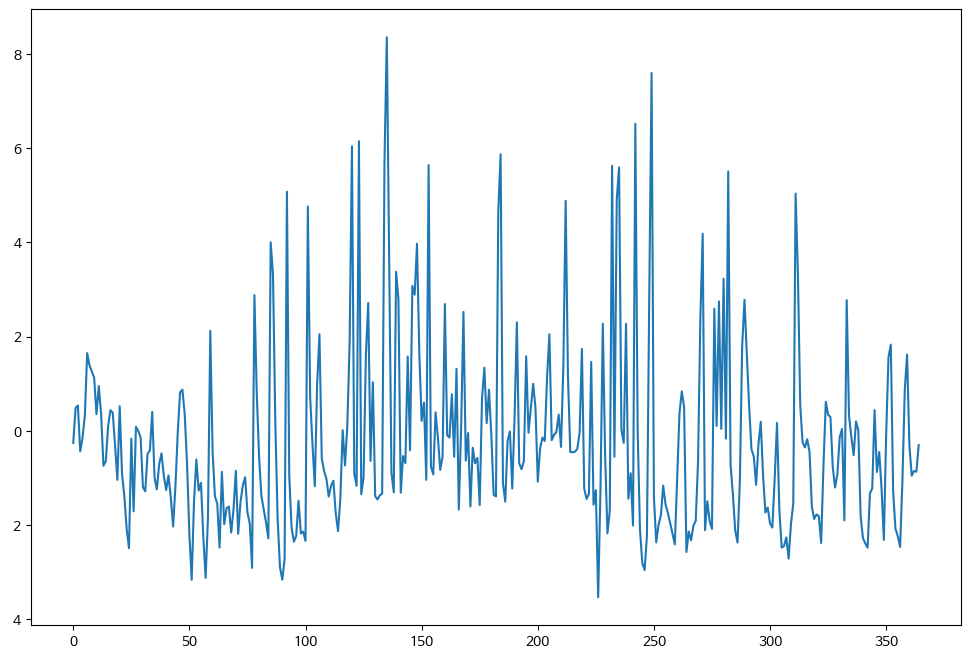

In [ ]:
plt.figure(figsize=(12,8), dpi=100)
plt.plot(np.arange(365), residual)
plt.show()



In [ ]:
# 융박스 검정
from statsmodels.stats.diagnostic import acorr_ljungbox, het_goldfeldquandt
print(acorr_ljungbox(residual, lags=20, return_df=True))
print(het_goldfeldquandt(residual))



      lb_stat     lb_pvalue
1   38.724409  4.880673e-10
2   38.870654  3.625306e-09
3   39.470019  1.380005e-08
4   39.561440  5.333386e-08
5   39.605128  1.793765e-07
6   42.595225  1.402568e-07
7   60.446425  1.229381e-10
8   61.753331  2.108672e-10
9   61.897932  5.766414e-10
10  62.254003  1.353972e-09
11  62.440432  3.253972e-09
12  63.479161  5.201818e-09
13  67.224479  2.592516e-09
14  82.416790  1.005475e-11
15  85.578284  6.576448e-12
16  85.686162  1.546956e-11
17  85.868118  3.417820e-11
18  86.244471  6.773735e-11
19  89.356854  4.311554e-11
20  92.034826  3.260415e-11


TypeError: ignored

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


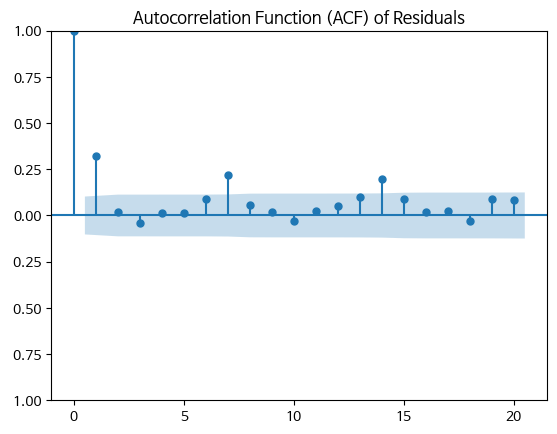

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


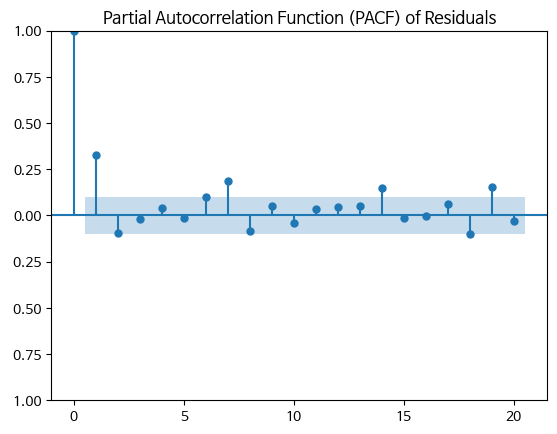

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming 'residuals' is a pandas Series or numpy array of residuals
plot_acf(residual, lags=20)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.show()

plot_pacf(residual, lags=20)
plt.title('Partial Autocorrelation Function (PACF) of Residuals')
plt.show()

In [ ]:
train_residual = np.array(pred_prophet['yhat'].head(1096)) - np.array(train['y'])

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


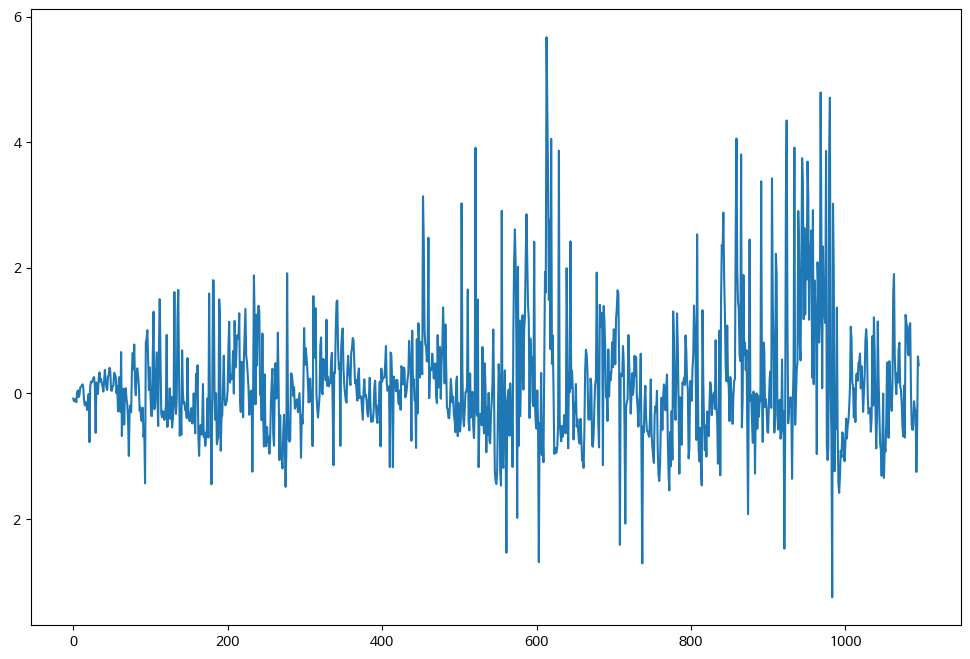

In [ ]:
plt.figure(figsize=(12,8), dpi=100)
plt.plot(np.arange(1096), train_residual)
plt.show()



In [ ]:
1461-365

1096